In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

## Loading the data...

In [2]:
data = '/media/mcamp/LocalSSHD/PythonProjects/Datasets/MSC641_Datasets/Clothing_store_training_test.csv'
df = pd.read_csv(data)

In [3]:
df.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,ln lifetime ave time betw visits,ln product uniformity,sqrt responded,flag returns,flag response rate,flag markdown,sqrt spending months 2 3,sqrt spending months 4 5 6,flag spending months 4 5 6,flag spending months 2 3
0,9.955600e+12,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,4.709530,3.459781,0.000000,F,F,T,0.000000,0.000000,F,F
1,9.955600e+12,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,3.772761,3.487987,1.414214,T,T,T,9.055937,10.954451,T,T
2,9.955600e+12,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,4.228293,4.605170,0.000000,F,F,T,0.000000,0.000000,F,F
3,9.955600e+12,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,3.294354,3.147165,2.449490,F,T,T,10.244023,16.399085,T,T
4,9.955600e+12,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,3.198673,3.350606,0.000000,F,F,T,9.350936,0.000000,F,T


In [4]:
df.shape

(28799, 119)

In another notebook I ran a correlation test and decided that these would be the variables to use for any model because they were least correlated with one another.

In [5]:
vars = ['CLUSTYPE', 'WEB', 'AXSPEND', 'AMSPEND','HHKEY',
'ZIP_CODE',
'REC',
'FRE',
'MON',
'CC_CARD',
'AVRG',
'PC_CALC20',
'PSWEATERS',
'PKNIT_TOPS',
'PKNIT_DRES',
'PBLOUSES',
'PJACKETS',
'PCAR_PNTS',
'PCAS_PNTS',
'PSHIRTS',
'PDRESSES',
'PSUITS',
'POUTERWEAR',
'PJEWELRY',
'PFASHION',
'PLEGWEAR',
'sqrt sweaters',
'sqrt knit tops',
'sqrt knit dresses',
'sqrt blouses',
'sqrt jackets',
'sqrt career pants',
'sqrt casual pants',
'sqrt shirts',
'sqrt dresses',
'sqrt suits',
'sqrt outerwear',
'sqrt jewelry',
'sqrt fashion',
'sqrt legwear',
'sqrt collectibles',
'flag sweaters',
'flag knit tops',
'flag knit dresses',
'flag blouses',
'flag jackets',
'flag career pants',
'flag casual pants',
'flag shirts',
'flag dresses',
'flag suits',
'flag outerwear',
'flag jewelry',
'flag fashion',
'flag legwear',
'flag collectibles',
'sqrt spending AM']

In [6]:
vars = ['CLUSTYPE', 'WEB', 'AXSPEND', 'AMSPEND',
#         'HHKEY',
'ZIP_CODE',
'REC',
'FRE',
'MON',
'CC_CARD',
'AVRG',
'PC_CALC20',
'PSWEATERS',
'PKNIT_TOPS',
'PKNIT_DRES',
'PBLOUSES',
'PJACKETS',
'PCAR_PNTS',
'PCAS_PNTS',
'PSHIRTS',
'PDRESSES',
'PSUITS',
'POUTERWEAR',
'PJEWELRY',
'PFASHION',
'PLEGWEAR']

Making a list for calling our independent and dependent variables

In [7]:
y_cols = 'RESP'
x_cols = vars
# x_cols.remove(y_cols)

In [8]:
dfdtype = pd.DataFrame(df.dtypes)
flag_cols = list(dfdtype[dfdtype.iloc[:,0] == 'object'].index)

Replace string values with integer values for our model.

In [9]:
df = df.replace(['Y', 'N'], [1, 0])
df = df.replace(['T', 'F'], [1, 0])

Check the number percentage of positive repsonses in the data. We see the majority of the responses are negative. We will need to take this into account when making our model(s).

In [10]:
df['RESP'].value_counts()

0    24037
1     4762
Name: RESP, dtype: int64

In [11]:
4762/24037

0.19811124516370596

In [12]:
df.to_csv('clothing_store_encoded_flags.csv') #saving the data off so that we don't have to reconvert the variables

Sub sampling the negative responses so that we make a balanced training dataset.

In [13]:
zerodf = df[df[y_cols] == 0].sample(4762)
onedf = df[df[y_cols] == 1]

newdf = pd.concat([zerodf, onedf], axis=0)
newdf[y_cols].value_counts()

1    4762
0    4762
Name: RESP, dtype: int64

In [14]:
df[y_cols].value_counts()

0    24037
1     4762
Name: RESP, dtype: int64

In [15]:
newdf[y_cols].value_counts()

1    4762
0    4762
Name: RESP, dtype: int64

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import neighbors
newdf = newdf.dropna()

In [17]:
# Helper functions to calculate the performance of our models.
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(str(title.split('\n')[0])+'.png')
    plt.show()
    
def overall_error_rate(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fn = cnf_matrix[1,0]
    fp = cnf_matrix[0,1]
    tn = cnf_matrix[0,0]
    tp = cnf_matrix[1,1]
    n = len(y_test)
    return (fn+fp)/n

def sensitivity(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    tap = pd.DataFrame(y_test).iloc[:,0].value_counts()[1]
    tp = cnf_matrix[1,1]
    return tp/tap

def false_pos_rate(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fp = cnf_matrix[0,1]
    tan = pd.DataFrame(y_test).iloc[:,0].value_counts()[0]
    return fp/tan

def specificity(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    tn = cnf_matrix[0,0]
    tan = pd.DataFrame(y_test).iloc[:,0].value_counts()[0]
    return tn/tan

def false_neg_rate(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fn = cnf_matrix[1,0]
    tap = pd.DataFrame(y_test).iloc[:,0].value_counts()[1]
    return fn/tap

def prop_true_pos(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    try:
        tpp = pd.DataFrame(y_pred).iloc[:,0].value_counts()[1]
    except:
        return 0
    tp = cnf_matrix[1,1]
    return tp/tpp

def prop_true_neg(y_pred, y_test):
    cnf_matrix = confusion_matrix(y_test, y_pred)
    try:
        tn = cnf_matrix[0,0]
        tpn = pd.DataFrame(y_pred).iloc[:,0].value_counts()[0]
    except:
        return 0
    return tn/tpn

def get_descriptive_data(y_pred, y_test):
    print("Accuracy: %f%%" %(round(accuracy_score(y_test, y_pred)*100,2)))
    print("Overall Error Rate: %f%%" %(round(overall_error_rate(y_pred, y_test)*100,2)))
    print('False Positive Rate: %f%%' %(round(false_pos_rate(y_pred, y_test)*100,2)))
    print('False Negative Rate: %f%%' %(round(false_neg_rate(y_pred, y_test)*100,2)))
    print('Specificity: %f%%' %(round(specificity(y_pred, y_test)*100,2)))
    print("Sensitivity: %f%%" %(round(sensitivity(y_pred, y_test)*100,2)))
    print('Proportion True Positive: %f%%' %(round(prop_true_pos(y_pred, y_test)*100,2)))
    print('Proportion True Negative: %f%%' %(round(prop_true_neg(y_pred, y_test)*100,2)))

# Classifiers

Accuracy: 66.870000%
Overall Error Rate: 33.130000%
False Positive Rate: 22.900000%
False Negative Rate: 44.000000%
Specificity: 77.100000%
Sensitivity: 56.000000%
Proportion True Positive: 69.740000%
Proportion True Negative: 65.040000%


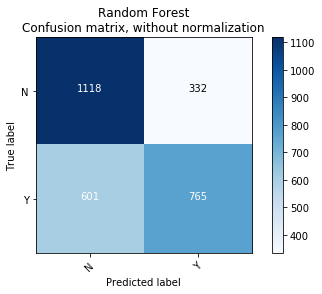

In [18]:
# Random Forrest
X_train, X_test, y_train, y_test = train_test_split(newdf[x_cols].as_matrix(), 
                                                    newdf[y_cols].as_matrix(), 
                                                    test_size=0.33, 
                                                    random_state=1)
rf = RandomForestClassifier(random_state=1, n_jobs=-1)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
get_descriptive_data(y_pred, y_test)

y_score = rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, y_score)
rf_roc_auc = auc(rf_fpr, rf_tpr)

y_pred = pd.Series(y_pred).replace([0,1], ['N','Y'])
y_test = pd.Series(y_test).replace([0,1], ['N','Y'])
class_names = list(y_pred.value_counts().index)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random Forest\nConfusion matrix, without normalization')

Accuracy: 71.910000%
Overall Error Rate: 28.090000%
False Positive Rate: 22.020000%
False Negative Rate: 34.780000%
Specificity: 77.980000%
Sensitivity: 65.220000%
Proportion True Positive: 72.890000%
Proportion True Negative: 71.180000%


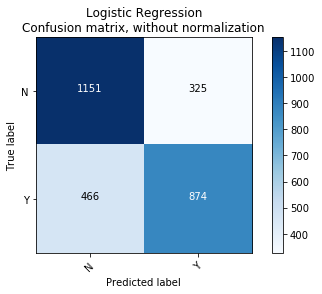

In [33]:
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(newdf[x_cols], newdf[y_cols], test_size=0.33, random_state=42)
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
get_descriptive_data(y_pred, y_test)

y_score = lr.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)

y_pred = pd.Series(y_pred).replace([0,1], ['N','Y'])
y_test = pd.Series(y_test).replace([0,1], ['N','Y'])
class_names = list(y_pred.value_counts().index)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Logistic Regression\nConfusion matrix, without normalization')

Accuracy: 71.910000%
Overall Error Rate: 28.090000%
False Positive Rate: 22.020000%
False Negative Rate: 34.780000%
Specificity: 77.980000%
Sensitivity: 65.220000%
Proportion True Positive: 72.890000%
Proportion True Negative: 71.180000%


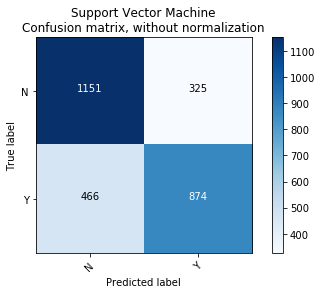

In [20]:
# Support Vector Machine
X_train, X_test, y_train, y_test = train_test_split(newdf[x_cols], newdf[y_cols], test_size=0.33, random_state=42)
svm = SVC(random_state=1)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

y_score = svm.decision_function(X_test)
svm_fpr, svm_tpr, _ = roc_curve(y_test, y_score)
svm_roc_auc = auc(svm_fpr, svm_tpr)

y_pred = pd.Series(y_pred).replace([0,1], ['N','Y'])
y_test = pd.Series(y_test).replace([0,1], ['N','Y'])
class_names = list(y_pred.value_counts().index)
get_descriptive_data(y_pred, y_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Support Vector Machine\nConfusion matrix, without normalization')

Accuracy: 65.980000%
Overall Error Rate: 34.020000%
False Positive Rate: 30.350000%
False Negative Rate: 38.060000%
Specificity: 69.650000%
Sensitivity: 61.940000%
Proportion True Positive: 64.950000%
Proportion True Negative: 66.840000%


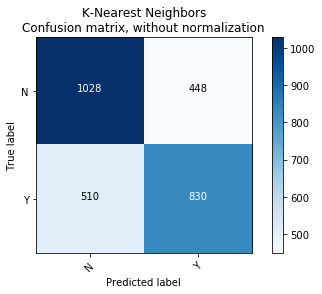

In [21]:
# K-Nearest Neighbors
X_train, X_test, y_train, y_test = train_test_split(newdf[x_cols], newdf[y_cols], test_size=0.33, random_state=42)
knn = neighbors.KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

y_score = knn.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, _ = roc_curve(y_test, y_score)
knn_roc_auc = auc(knn_fpr, knn_tpr)

y_pred = pd.Series(y_pred).replace([0,1], ['N','Y'])
y_test = pd.Series(y_test).replace([0,1], ['N','Y'])
class_names = list(y_pred.value_counts().index)
get_descriptive_data(y_pred, y_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='K-Nearest Neighbors\nConfusion matrix, without normalization')

# ROC Curve

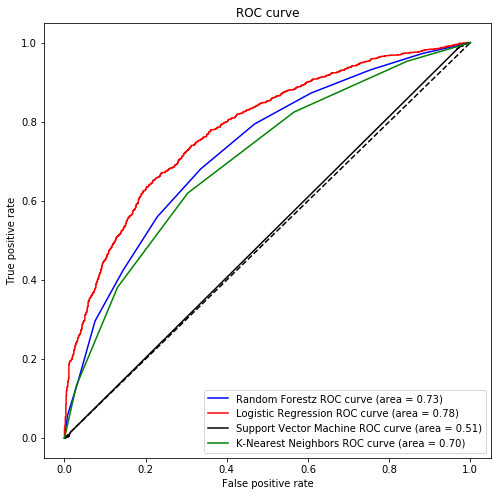

In [22]:
plt.figure(1, figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr,color='b', label='Random Forestz ROC curve (area = %0.2f)' % rf_roc_auc)
plt.plot(lr_fpr, lr_tpr,color='r', label='Logistic Regression ROC curve (area = %0.2f)' % lr_roc_auc)
plt.plot(svm_fpr, svm_tpr,color='k', label='Support Vector Machine ROC curve (area = %0.2f)' % svm_roc_auc)
plt.plot(knn_fpr, knn_tpr,color='g', label='K-Nearest Neighbors ROC curve (area = %0.2f)' % knn_roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig('roc_curve.png')
plt.show()

# K-Folds Testing

In [23]:
from sklearn.cross_validation import cross_val_score, KFold, LeavePOut

def KFold_test(X, y, folds, trained_model):
    n_folds    = len(folds)
    accuracies = []
    n    = X.shape[0]
    # Run K-folds
    for k in folds:
        cv     = KFold(n, n_folds=k, random_state=12, shuffle=True) if k > 0 else LeavePOut(n, p=abs(k))
        scores = cross_val_score(trained_model, X, y, cv=cv)
        accuracies.append(100 * scores.mean())
        print("K = %d, accuracy: %0.2f%%" % (k, accuracies[-1]))
    return accuracies

/home/mcamp/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
folds      = [2, 5, 100, 200, 500, 750, 1000]
knn_accuracies = KFold_test(newdf[x_cols], newdf[y_cols], folds, knn)

K = 2, accuracy: 64.66%
K = 5, accuracy: 65.04%
K = 100, accuracy: 65.47%
K = 200, accuracy: 65.48%
K = 500, accuracy: 65.49%
K = 750, accuracy: 65.46%
K = 1000, accuracy: 65.45%


In [25]:
lr_accuracies = KFold_test(newdf[x_cols], newdf[y_cols], folds, lr)

K = 2, accuracy: 71.04%
K = 5, accuracy: 71.33%
K = 100, accuracy: 71.03%
K = 200, accuracy: 71.06%
K = 500, accuracy: 71.05%
K = 750, accuracy: 71.06%
K = 1000, accuracy: 71.24%


In [26]:
svm_accuracies = KFold_test(newdf[x_cols], newdf[y_cols], folds, svm)

K = 2, accuracy: 52.50%
K = 5, accuracy: 52.50%
K = 100, accuracy: 52.50%
K = 200, accuracy: 52.51%
K = 500, accuracy: 52.49%
K = 750, accuracy: 52.54%
K = 1000, accuracy: 52.57%


In [27]:
rf_accuracies = KFold_test(newdf[x_cols], newdf[y_cols], folds, rf)

K = 2, accuracy: 68.25%
K = 5, accuracy: 67.87%
K = 100, accuracy: 68.30%
K = 200, accuracy: 67.30%
K = 500, accuracy: 68.38%
K = 750, accuracy: 68.35%
K = 1000, accuracy: 67.49%


In [28]:
#To save having to re-run these later if I want the actual accuracies
print('Random Forest Accuracies: ', rf_accuracies)
print('Linear Regression Accuracies: ', lr_accuracies)
print('Support Vector Machine Accuracies: ', svm_accuracies)
print('K-Nearest Neighbor Accuracies: ', knn_accuracies)

Random Forest Accuracies:  [68.251279309106835, 67.866623766449038, 68.296990424076597, 67.298172757475101, 68.379084967320253, 68.352525252525268, 67.490277777777791]
Linear Regression Accuracies:  [71.035776130842791, 71.3270422064831, 71.032558139534871, 71.058970099667775, 71.045751633986924, 71.061616161616172, 71.240277777777777]
Support Vector Machine Accuracies:  [52.49924634733658, 52.499487505311606, 52.500273597811223, 52.509136212624583, 52.488888888888894, 52.537373737373741, 52.570833333333333]
K-Nearest Neighbor Accuracies:  [64.662738804185622, 65.035385891530325, 65.472503419972654, 65.484219269102994, 65.486274509803906, 65.455555555555549, 65.445833333333326]


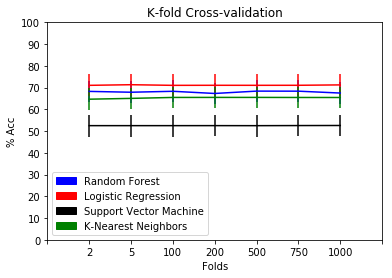

In [29]:
n_folds = len(folds)
plt.figure()
plt.errorbar(range(1, n_folds + 1), rf_accuracies, yerr=[5] * n_folds, c='b') 
plt.errorbar(range(1, n_folds + 1), lr_accuracies, yerr=[5] * n_folds, c='r') 
plt.errorbar(range(1, n_folds + 1), svm_accuracies, yerr=[5] * n_folds, c='k')
plt.errorbar(range(1, n_folds + 1), knn_accuracies, yerr=[5] * n_folds, c='g')# Use 5% for the error bars
ax = plt.gca()
plt.xticks(range(0, n_folds + 2), [''] + [str(k) for k in folds] + [''])
plt.yticks(range(0, 110, 10))
plt.title("K-fold Cross-validation")
plt.xlabel("Folds")
plt.ylabel("% Acc")

rf_patch = mpatches.Patch(color='b', label='Random Forest')
lr_patch = mpatches.Patch(color='r', label='Logistic Regression')
svm_patch = mpatches.Patch(color='k', label='Support Vector Machine')
knn_patch = mpatches.Patch(color='g', label='K-Nearest Neighbors')
plt.legend(handles=[rf_patch, lr_patch, svm_patch, knn_patch])
plt.savefig('kfold_chart.png')
# print("Saved the chart into ")
plt.show()

# Contributing Feature Analysis

In [24]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from treeinterpreter import treeinterpreter as ti
from sklearn.datasets import load_boston
from tqdm import tqdm 
contrib_sum = np.zeros((25,2))

for i in tqdm(range(100)):
    # Random Forrest
    X_train, X_test, y_train, y_test = train_test_split(newdf[x_cols].as_matrix(), 
                                                        newdf[y_cols].as_matrix(), 
                                                        test_size=2820, 
                                                        random_state=i)
    rf = RandomForestClassifier(random_state=i, n_jobs=-1)

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    prediction, bias, contributions = ti.predict(rf, X_test)
    # contrib_sum = contributions[0]
    for i in range(contributions.shape[0]):
        contrib_sum += contributions[i]

100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


In [25]:
contrib_sum = contrib_sum/100
contrib = pd.DataFrame(contrib_sum)
contrib.columns = ['Neg_Contributions', 'Pos_Contributions']
contrib['Features'] = newdf[x_cols].columns
contrib = contrib.set_index(['Features'])
contrib.sort_values('Pos_Contributions', ascending=[False])
#TODO: Make Pie Chart of the pos contributions

,Neg_Contributions,Pos_Contributions
Features,,
REC,-1.757851,1.757851
ZIP_CODE,-1.002181,1.002181
CLUSTYPE,-0.747657,0.747657
CC_CARD,-0.202108,0.202108
PKNIT_TOPS,-0.165676,0.165676
AVRG,-0.118930,0.118930
PSUITS,-0.029336,0.029336
PC_CALC20,-0.022184,0.022184
PSHIRTS,-0.017036,0.017036


In [26]:
pos_feat = contrib[contrib['Pos_Contributions'] >= 0]['Pos_Contributions']
neg_feat = contrib[contrib['Neg_Contributions'] >= 0]['Neg_Contributions']
total_neg = neg_feat.sum()
total_pos = pos_feat.sum()


In [27]:
pos_feat.to_dict()

{'AVRG': 0.11893031120656512,
 'CC_CARD': 0.20210787353760329,
 'CLUSTYPE': 0.7476573649418633,
 'PC_CALC20': 0.022184160109205014,
 'PKNIT_TOPS': 0.1656755248320696,
 'PSHIRTS': 0.017035537657457359,
 'PSUITS': 0.029335997274420135,
 'REC': 1.7578509197438614,
 'ZIP_CODE': 1.0021806367087716}

/home/mcamp/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


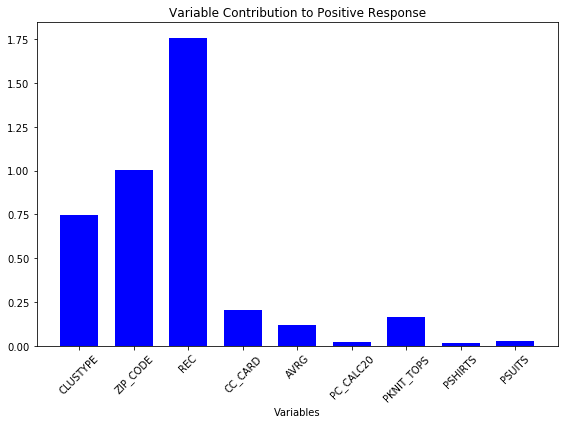

In [28]:
n_groups = pos_feat.shape[0]

fig, ax = plt.subplots(figsize=(8,6))

index = np.arange(pos_feat.shape[0])
bar_width = .7

opacity = 1
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, pos_feat, bar_width,
                 alpha=opacity,
                 color='b')


plt.xlabel('Variables')
plt.title('Variable Contribution to Positive Response')
plt.xticks(index, (pos_feat.index),rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

/home/mcamp/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


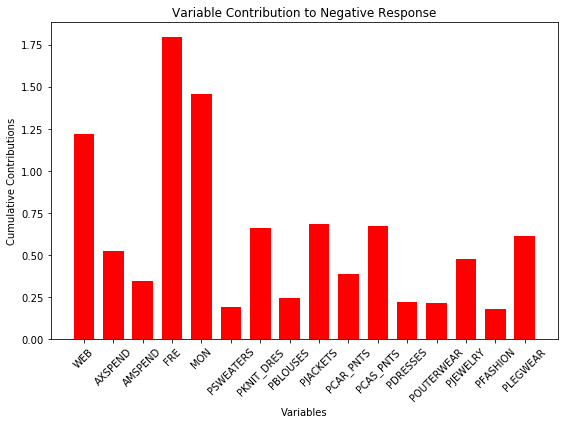

In [29]:
n_groups = neg_feat.shape[0]

fig, ax = plt.subplots(figsize=(8,6))

index = np.arange(neg_feat.shape[0])
bar_width = .7

opacity = 1
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(index, neg_feat, bar_width,
                 alpha=opacity,
                 color='r')


plt.xlabel('Variables')
plt.ylabel('Cumulative Contributions')
plt.title('Variable Contribution to Negative Response')
plt.xticks(index, (neg_feat.index),rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

/home/mcamp/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


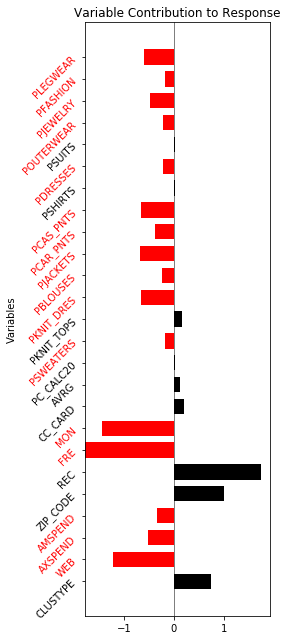

In [30]:
contrib['color'] = contrib['Pos_Contributions'] > 0
n_groups = contrib['Pos_Contributions'].shape[0]

fig, ax = plt.subplots(figsize=(4,9))

index = np.arange(contrib['Pos_Contributions'].shape[0])
bar_width = .7

opacity = 1
error_config = {'ecolor': '0.3'}

rects1 = plt.barh(index, contrib['Pos_Contributions'], bar_width,
                 alpha=opacity,
                 color=contrib.color.map({True: 'k', False: 'r'}))


plt.ylabel('Variables')
plt.title('Variable Contribution to Response')
plt.yticks(index, (contrib.index),rotation=45)
plt.legend()
colors = contrib.color.map({True: 'k', False: 'r'})
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
plt.tight_layout()
plt.axvline(x=0, linewidth=.5, color='k', linestyle='-')
plt.savefig('var_contrib.png')
plt.show()

/home/mcamp/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


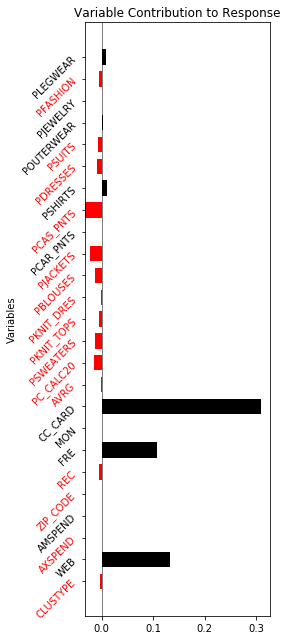

In [34]:
LR_contrib = pd.DataFrame({'Pos_Contributions':lr.coef_[0], 
                           'Features': X_train.columns}).set_index('Features')

LR_contrib['color'] = LR_contrib['Pos_Contributions'] > 0
n_groups = LR_contrib['Pos_Contributions'].shape[0]

fig, ax = plt.subplots(figsize=(4,9))

index = np.arange(LR_contrib['Pos_Contributions'].shape[0])
bar_width = .7

opacity = 1
error_config = {'ecolor': '0.3'}

rects1 = plt.barh(index, LR_contrib['Pos_Contributions'], bar_width,
                 alpha=opacity,
                 color=LR_contrib.color.map({True: 'k', False: 'r'}))


plt.ylabel('Variables')
plt.title('Variable Contribution to Response')
plt.yticks(index, (LR_contrib.index),rotation=45)
plt.legend()
colors = LR_contrib.color.map({True: 'k', False: 'r'})
for ytick, color in zip(ax.get_yticklabels(), colors):
    ytick.set_color(color)
plt.tight_layout()
plt.axvline(x=0, linewidth=.5, color='k', linestyle='-')
plt.savefig('lr_var_contrib.png')
plt.show()

# Calculate Savings

In [32]:
flyer = .35
population = 1958748
total_cost = population * flyer

In [40]:
avg_spend = df[df['RESP'] == 1]['AVRG'].mean()
pos_resp = df[df['RESP'] == 1].shape[0]
neg_resp = df[df['RESP'] == 0].shape[0]

#Calculate the profit from our model
TNeg = 0 # Predicted No Response Cost nothing
FNeg = -362 * flyer # False neg response cost err * cost of the flyer
FPos = 528 * avg_spend # False pos repsonse  = err * opportunity cost (avg spend)
TPos = 806 * avg_spend # Positive reposne * avg spend
model_profit = TPos + TNeg + FNeg + FPos

no_model_profit = pos_resp * avg_spend + (neg_resp * flyer) * -1


cost_delta = (model_profit - no_model_profit) / no_model_profit
no_model_acc = pos_resp/df.shape[0]
rf_model_acc = accuracy_score(y_test, y_pred)
delta_acc = (no_model_acc - rf_model_acc) * -1
total_rev = no_model_acc * population * avg_spend

In [41]:
model_profit - no_model_profit

-340307.4731247351

In [42]:
no_model_profit

475835.3899999967

In [43]:
model_profit #Our

135527.91687526158

In [44]:
no_model_rev 

NameError: name 'no_model_rev' is not defined

In [45]:
total_cost

685561.7999999999